In [ ]:
# default_exp analyses

# Plotting Rework

I use `psifr` a lot. One stress point I've experienced with it is that its plotting functions are a bit inflexible. Functions' inclusion of a `facet_kws` argument keyword that can accept an arbitrary number of plotting arguments for called seaborn functions helps a lot, but on the other hand the plotting library's use of FacetGrid gets in the way of further customization. `FacetGrid`s are figure-level constructs so using them makes it impossible for people using the library to compose multiple figures (e.g. an SPC with a CRP). Alternatively, users might sometimes want to customize the `FacetGrid` itself -- controlling stuff like figure size and how axes are rendered.

To give users full access to `seaborn`'s features, a better approach might be to make psifr's plotting functions _mappable_ to figures according to `seaborn` or `matplotlib`'s internal logic. The [`seaborn.FacetGrid.map_dataframe`](https://seaborn.pydata.org/generated/seaborn.FacetGrid.map_dataframe.html#seaborn.FacetGrid.map_dataframe) page outlines what this would look like:

> A plotting function that takes data and keyword arguments. Unlike the `map` method, a function used here must "understand" Pandas objects. It also must plot to the currently active matplotlib Axes and take a `color` keyword argument. If faceting on the `hue` dimension, it must also take a `label` keyword argument.

`psifr`'s plotting functions already take data and keyword arguments. We just have to have the functions return a plot instead of a figure object. A plotting function defined this way can be used on its own - just like how `seaborn.lineplot` works just fine whether you pass it into a FacetGrid with `seaborn.FacetGrid.map_dataframe`. 

What follows are some examples rewriting `fr.plot_spc`, `fr.plot_lag_crp`, and `fr.plot_pfr` assuming that data is organized as you suggest in `psifr`'s tutorial.

## Data Preparation

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from compmemlearn.datasets import prepare_murdock1970_data

trials, events, list_length = prepare_murdock1970_data('../data/mo1970.txt')
events.head()

,subject,list,item,input,output,study,recall,repeat,intrusion
0,1,1,1,1,NaN,True,False,0,False
1,1,1,2,2,NaN,True,False,0,False
2,1,1,3,3,NaN,True,False,0,False
3,1,1,4,4,NaN,True,False,0,False
4,1,1,5,5,NaN,True,False,0,False


## SPC Demo

### Demo Function

In [63]:
# export
from psifr import fr
import seaborn as sns

def plot_spc(data, **facet_kws):
    
    sns.lineplot(
        data=fr.spc(data), x='input', y='recall', **facet_kws)

### Plotting

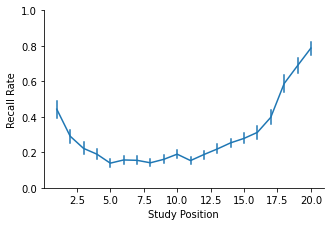

In [64]:
g = sns.FacetGrid(dropna=False, data=events, aspect=1.5)
g.map_dataframe(plot_spc, err_style='bars')
g.set_xlabels('Study Position')
g.set_ylabels('Recall Rate')
g.set(ylim=(0, 1))

plt.show()

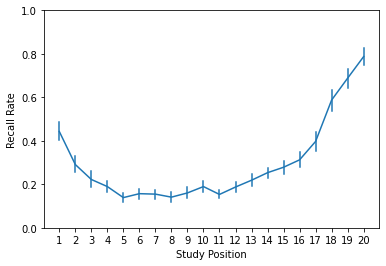

In [65]:
plot_spc(events, err_style='bars')
plt.xlabel('Study Position')
plt.ylabel('Recall Rate')
plt.xticks(np.arange(1, 21), np.arange(1, 21))
plt.ylim((0, 1))
plt.show()

## Lag-CRP Demo
The contiguity effect illustrates how episodic associations are graded, exhibiting power-function decay with increasing lag. Recall of an item has a tendency to evoke not only adjacent list items, but other nearby items as well. In addition, episodic associations appear to be asymmetrical, favoring retrieval of items in the forward order.

To measure the contiguity effect, we often produce lag-CRP curves. "Lag-CRP" measures the conditional probability of recalling an item as a function of its adjacency (**lag**) in the study list to the the last recalled item. To find this in our free recall data, for every recall a participant made in a dataset, we measure how adjacent the recalled item was from the *next* item the participant recalled -- its serial lag. For example, if a subject recalls the third item presented in a list and then the fourth, the lag of the next item recalled is +1. If a subject instead recalls the first item after recalling the third item, the measured lag is -2. We also track across recalls which lag transitions were possible based on which items were not already retrieved. Once we've tallied up all actual and possible lag transitions across a dataset, we plot for each lag the ratio of actual transitions divided by position transitions to visualize the conditional probability of each lag transition.

### Demo Function

In [80]:
# export

def plot_lag_crp(data, max_lag=5, **facet_kws):
    
    filt_neg = f'{-max_lag} <= lag < 0'
    filt_pos = f'0 < lag <= {max_lag}'
    
    crp_data = fr.lag_crp(data)
    
    sns.lineplot(
        data=crp_data.query(filt_neg), 
        x='lag', y='prob', **facet_kws)
    sns.lineplot(
        data=crp_data.query(filt_pos), 
        x='lag', y='prob', **facet_kws)

### Plotting

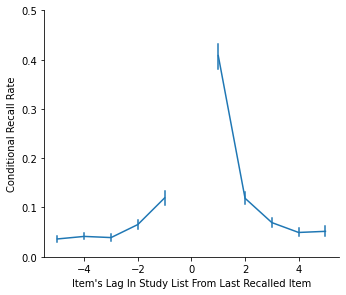

In [82]:
g = sns.FacetGrid(dropna=False, data=events, height=4, aspect=1.2)
g.map_dataframe(plot_lag_crp, err_style='bars')
g.set(ylim=(0, .5))

g.set_xlabels('Item\'s Lag In Study List From Last Recalled Item')
g.set_ylabels('Conditional Recall Rate')

plt.show()

## PFR

### Demo Function

In [85]:
# export

def plot_pfr(data, max_lag=5, **facet_kws):
    
    filt_neg = f'{-max_lag} <= lag < 0'
    filt_pos = f'0 < lag <= {max_lag}'
    
    pfr_data = fr.pnr(data).query('output <= 1')
    
    sns.lineplot(
        data=pfr_data, x='input', y='prob', **facet_kws)
    sns.lineplot(
        data=pfr_data, x='input', y='prob', **facet_kws)

### Plotting

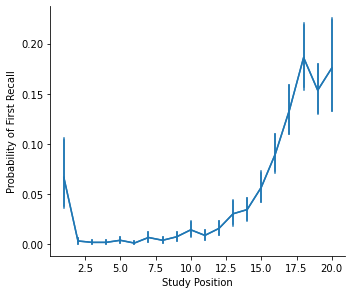

In [86]:
g = sns.FacetGrid(dropna=False, data=events, height=4, aspect=1.2)
g.map_dataframe(plot_pfr, err_style='bars')

g.set_xlabels('Study Position')
g.set_ylabels('Probability of First Recall')

plt.show()